In [30]:
import pandas as pd
import numpy as np
import os
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.stats import norm, logistic
from scipy.optimize import minimize

from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss


In [31]:
data_folder = 'data'
df = pd.read_csv(os.path.join(data_folder,'mimiciv_traindata.csv'))
df.head()

import numpy as np
from sklearn.impute import KNNImputer
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.model_selection import train_test_split


# KNN Imputation
knn_imputer = KNNImputer(n_neighbors=3)
df_imputed = knn_imputer.fit_transform(df)


# Convert the result back to a DataFrame
df_imputed = pd.DataFrame(df_imputed, columns=df.columns)


# Features & Target
x = df_imputed[[
    'Fraction inspired oxygen_mean', 'Fraction inspired oxygen_min', 'Fraction inspired oxygen_max', \
    'Glucose_mean', 'Glucose_min', 'Glucose_max', \
    'Heart Rate_mean', 'Heart Rate_min', 'Heart Rate_max',\
    'Mean blood pressure_mean', 'Mean blood pressure_min', 'Mean blood pressure_max', \
    'Diastolic blood pressure_mean', 'Diastolic blood pressure_min', 'Diastolic blood pressure_max',\
    'Systolic blood pressure_mean', 'Systolic blood pressure_min', 'Systolic blood pressure_max',\
    'Oxygen saturation_mean', 'Oxygen saturation_min', 'Oxygen saturation_max',\
    'Respiratory rate_mean', 'Respiratory rate_min', 'Respiratory rate_max',\
    'Temperature_mean', 'Temperature_min', 'Temperature_max',\
    'Weight_mean', 'Weight_min', 'Weight_max',\
    'pH_mean', 'pH_min', 'pH_max']]
y = df_imputed['mortality']


# Applying SMOTE
smote = SMOTE(random_state = 42)
x_resampled, y_resampled = smote.fit_resample(x, y)


print('Original Dataset Shape:', y.value_counts())
print('\nResampled Dataset Shape:', y_resampled.value_counts())


print ('\n-------------------------------------------------------------------')
# Function to Detect Outliers using IQR
def detect_outlier_iqr(data):
  outliers = {}
  for column in df.columns:
      Q1 = data[column].quantile(0.25)
      Q3 = data[column].quantile(0.75)
      IRQ = Q3 - Q1
      lower_bound = Q1 - 1.5*IRQ
      upper_bound = Q3 + 1.5*IRQ
      outliers[column] = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
  return outliers

# Combine feataures and target variable for outlier detection
resampled_data = pd.DataFrame(x_resampled, columns=x.columns)
resampled_data['mortality'] = y_resampled

# Checking for Outliers in the Resampled Data
outliers_in_resampled = detect_outlier_iqr(pd.DataFrame(resampled_data))
for feature, outliers in outliers_in_resampled.items():
    print(f"Outliers detected in'{feature}':")
    print(outliers)
    print('\n~~~~~~~~~~~~~~~~~~~~~')



Original Dataset Shape: 0.0    4232
1.0    1415
Name: mortality, dtype: int64

Resampled Dataset Shape: 1.0    4232
0.0    4232
Name: mortality, dtype: int64

-------------------------------------------------------------------
Outliers detected in'Fraction inspired oxygen_mean':
      Fraction inspired oxygen_mean  Fraction inspired oxygen_min  \
60                         1.000000                      1.000000   
65                         1.000000                      1.000000   
98                         1.000000                      1.000000   
118                        0.862500                      0.700000   
158                        0.833333                      0.500000   
...                             ...                           ...   
8279                       0.875009                      0.500075   
8308                       0.830007                      0.807035   
8338                       0.815078                      0.500000   
8429                       0.9

In [32]:
import lightgbm as lgb
print(lgb.__version__)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 0)


lgb_train = lgb.Dataset(X_train, y_train, params={'feature_pre_filter':False})
lgb_test = lgb.Dataset(X_test, y_test, params={'feature_pre_filter':False})




4.5.0


In [33]:
from sklearn.metrics import f1_score

threshold=0.5

# Define the F1 Score metric
def F1_metric(y_pred,dataset):
  y_true=dataset.get_label()
  F1 = f1_score(y_true, y_pred>threshold)
  return "F1",F1,True



def sigmoid(x):
    return 1 / (1 + np.exp(-x))



In [34]:
def black_box_function(num_leaves, learning_rate,num_iterations,lambda_l1,lambda_l2,max_depth,min_data_in_leaf):
    """Function with unknown internals we wish to maximize.

    This is just serving as an example, for all intents and
    purposes think of the internals of this function, i.e.: the process
    which generates its output values, as unknown.
    """

    n_estimators = int(num_leaves)
    num_iterations=int(num_iterations)
    max_depth=int(max_depth)
    num_leaves=int(num_leaves)
    min_data_in_leaf = int(min_data_in_leaf)

    lambda_l1=round(float(lambda_l1),2)
    lambda_l2=round(float(lambda_l2),2)
    learning_rate=round(float(learning_rate),2)




    # https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMClassifier.html

    # Using built-in objective
    lgbm_params = {
        'metric':['cross_entropy'],
        'objective': 'cross_entropy',
        'random_seed': 0,
        'force_col_wise': 'true',
        'is_unbalance':True,
        'data_sample_strategy':'bagging',
        'save_binary':True,
        'early_stopping_rounds' : 13,

        'num_leaves':num_leaves,
        'learning_rate': learning_rate,
        'lambda_l1':lambda_l1,
        'lambda_l2':lambda_l2,
        'max_depth':max_depth,
        'num_iterations':num_iterations,
        'min_data_in_leaf':min_data_in_leaf,

        #'evals_result': evals_result,


        #**best_params
    }


    model = lgb.train(
            params=lgbm_params,
            train_set=lgb_train,
            num_boost_round=100,
            feval = F1_metric,
            valid_sets=[lgb_train,lgb_test],

        )


    #clf._Booster=model
    y_pred=model.predict(X_train)>threshold

    return f1_score(y_train,y_pred)

In [35]:
from bayes_opt import BayesianOptimization

# Bounded region of parameter space
pbounds = {
    'num_leaves': (5, 50),
    'learning_rate': (0.05, 0.2),
    'num_iterations': (10, 100),
    'lambda_l1' :(0.01,0.3),
    'lambda_l2':(0.01,0.3),
    'max_depth':(100,300),
    'min_data_in_leaf':(30,200)
}

optimizer = BayesianOptimization(
    f=black_box_function,
    pbounds=pbounds,
    random_state=1,
)

optimizer.maximize(

    init_points=1,
    n_iter=10
)



|   iter    |  target   | lambda_l1 | lambda_l2 | learni... | max_depth | min_da... | num_it... | num_le... |
-------------------------------------------------------------------------------------------------------------
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [cross_entropy:Init]: (objective) labels passed interval [0, 1] check
[LightGBM] [Info] [cross_entropy:Init]: (metric) labels passed interval [0, 1] check
[LightGBM] [Info] [cross_entropy:Init]: sum-of-weights = 3952.000000
[LightGBM] [Info] Total Bins 5297
[LightGBM] [Info] Number of data points in the train set: 3952, number of used features: 33
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [cross_entropy:Init]: (metric) labels passed interval [0, 1] check
[LightGBM] [Info] [cross_entropy:Init]: sum-of-weights = 1695.000000
[LightGBM] [Info] [cross_entropy:BoostFromScore]: pavg = 0.246711 -> initscore = -1.116234
[LightG

/Users/gisellechan/anaconda3/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/gisellechan/anaconda3/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/gisellechan/anaconda3/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/gisellechan/anaconda3/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iter

/Users/gisellechan/anaconda3/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] [cross_entropy:Init]: (objective) labels passed interval [0, 1] check
[LightGBM] [Info] [cross_entropy:Init]: (metric) labels passed interval [0, 1] check
[LightGBM] [Info] [cross_entropy:Init]: sum-of-weights = 3952.000000
[LightGBM] [Info] Total Bins 5297
[LightGBM] [Info] Number of data points in the train set: 3952, number of used features: 33
[LightGBM] [Info] [cross_entropy:Init]: (metric) labels passed interval [0, 1] check
[LightGBM] [Info] [cross_entropy:Init]: sum-of-weights = 1695.000000
[LightGBM] [Info] [cross_entropy:BoostFromScore]: pavg = 0.246711 -> initscore = -1.116234
[LightGBM] [Info] Start training from score -1.116234
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 13 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with pos

/Users/gisellechan/anaconda3/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] [cross_entropy:Init]: (objective) labels passed interval [0, 1] check
[LightGBM] [Info] [cross_entropy:Init]: (metric) labels passed interval [0, 1] check
[LightGBM] [Info] [cross_entropy:Init]: sum-of-weights = 3952.000000
[LightGBM] [Info] Total Bins 5297
[LightGBM] [Info] Number of data points in the train set: 3952, number of used features: 33
[LightGBM] [Info] [cross_entropy:Init]: (metric) labels passed interval [0, 1] check
[LightGBM] [Info] [cross_entropy:Init]: sum-of-weights = 1695.000000
[LightGBM] [Info] [cross_entropy:BoostFromScore]: pavg = 0.246711 -> initscore = -1.116234
[LightGBM] [Info] Start training from score -1.116234
Training until validation scores don't improve for 13 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with pos

/Users/gisellechan/anaconda3/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[70]	training's cross_entropy: 0.466879	training's F1: 0.296482	valid_1's cross_entropy: 0.505972	valid_1's F1: 0.253211
| 7         | 0.2965    | 0.1887    | 0.2746    | 0.08007   | 238.1     | 167.5     | 70.29     | 5.399     |
[LightGBM] [Info] [cross_entropy:Init]: (objective) labels passed interval [0, 1] check
[LightGBM] [Info] [cross_entropy:Init]: (metric) labels passed interval [0, 1] check
[LightGBM] [Info] [cross_entropy:Init]: sum-of-weights = 3952.000000
[LightGBM] [Info] Total Bins 5297
[LightGBM] [Info] Number of data points in the train set: 3952, number of used features: 33
[LightGBM] [Info] [cross_entropy:Init]: (metric) labels passed interval [0, 1] check
[LightGBM] [Info] [cross_entropy:Init]: sum-of-weights = 1695.000000
[LightGBM] [Info] [cross_entropy:BoostFromScore]: pavg = 0.246711 -> initscore = -1.116234
[LightGBM] [Info] Start training from score -1.116234
[LightGBM] [Warning] No further splits with positive g

/Users/gisellechan/anaconda3/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Did not meet early stopping. Best iteration is:
[13]	training's cross_entropy: 0.473301	training's F1: 0.127135	valid_1's cross_entropy: 0.513635	valid_1's F1: 0.0817204
| 8         | 0.1271    | 0.05173   | 0.129     | 0.1268    | 277.6     | 173.8     | 13.59     | 46.05     |


/Users/gisellechan/anaconda3/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] [cross_entropy:Init]: (objective) labels passed interval [0, 1] check
[LightGBM] [Info] [cross_entropy:Init]: (metric) labels passed interval [0, 1] check
[LightGBM] [Info] [cross_entropy:Init]: sum-of-weights = 3952.000000
[LightGBM] [Info] Total Bins 5297
[LightGBM] [Info] Number of data points in the train set: 3952, number of used features: 33
[LightGBM] [Info] [cross_entropy:Init]: (metric) labels passed interval [0, 1] check
[LightGBM] [Info] [cross_entropy:Init]: sum-of-weights = 1695.000000
[LightGBM] [Info] [cross_entropy:BoostFromScore]: pavg = 0.246711 -> initscore = -1.116234
[LightGBM] [Info] Start training from score -1.116234
Training until validation scores don't improve for 13 rounds
Did not meet early stopping. Best iteration is:
[28]	training's cross_entropy: 0.454385	training's F1: 0.33279	valid_1's cross_entropy: 0.503628	valid_1's F1: 0.282648
| 9         | 0.3328    | 0.2498    | 0.1806    | 0.1722    | 243.0     | 159.3     | 28.96     | 7.992 

/Users/gisellechan/anaconda3/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] [cross_entropy:Init]: (objective) labels passed interval [0, 1] check
[LightGBM] [Info] [cross_entropy:Init]: (metric) labels passed interval [0, 1] check
[LightGBM] [Info] [cross_entropy:Init]: sum-of-weights = 3952.000000
[LightGBM] [Info] Total Bins 5297
[LightGBM] [Info] Number of data points in the train set: 3952, number of used features: 33
[LightGBM] [Info] [cross_entropy:Init]: (metric) labels passed interval [0, 1] check
[LightGBM] [Info] [cross_entropy:Init]: sum-of-weights = 1695.000000
[LightGBM] [Info] [cross_entropy:BoostFromScore]: pavg = 0.246711 -> initscore = -1.116234
[LightGBM] [Info] Start training from score -1.116234
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 13 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with pos

/Users/gisellechan/anaconda3/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] [cross_entropy:Init]: (objective) labels passed interval [0, 1] check
[LightGBM] [Info] [cross_entropy:Init]: (metric) labels passed interval [0, 1] check
[LightGBM] [Info] [cross_entropy:Init]: sum-of-weights = 3952.000000
[LightGBM] [Info] Total Bins 5297
[LightGBM] [Info] Number of data points in the train set: 3952, number of used features: 33
[LightGBM] [Info] [cross_entropy:Init]: (metric) labels passed interval [0, 1] check
[LightGBM] [Info] [cross_entropy:Init]: sum-of-weights = 1695.000000
[LightGBM] [Info] [cross_entropy:BoostFromScore]: pavg = 0.246711 -> initscore = -1.116234
[LightGBM] [Info] Start training from score -1.116234
Training until validation scores don't improve for 13 rounds
Early stopping, best iteration is:
[1]	training's cross_entropy: 0.551939	training's F1: 0	valid_1's cross_entropy: 0.567724	valid_1's F1: 0
| 11        | 0.0       | 0.2478    | 0.07596   | 0.08127   | 264.2     | 163.7     | 45.23     | 14.83     |


In [36]:
best_params=optimizer.max['params']

best_params['num_iterations']=int(best_params['num_iterations'])
best_params['num_leaves']=int(best_params['num_leaves'])
best_params['max_depth']=int(best_params['max_depth'])
best_params['min_data_in_leaf']=int(best_params['min_data_in_leaf'])

best_params['lambda_l1']=round(float(best_params['lambda_l1']),2)
best_params['lambda_l2']=round(float(best_params['lambda_l2']),2)
best_params['learning_rate']=round(float(best_params['learning_rate']),2)

print(best_params)




{'lambda_l1': 0.07, 'lambda_l2': 0.29, 'learning_rate': 0.13, 'max_depth': 249, 'min_data_in_leaf': 171, 'num_iterations': 37, 'num_leaves': 29}


In [37]:

os.makedirs('lightgbm', exist_ok=True)  
filew= open("lightgbm/lightgbm_best_params.json","w")
filew.write(str(best_params))
filew.close()

In [38]:

# https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMClassifier.html

# Using built-in objective
lgbm_params = {

        'metric':['cross_entropy'],
        'objective': 'cross_entropy',
        'random_seed': 0,
        'force_col_wise': 'true',
        'is_unbalance':True,
        'data_sample_strategy':'bagging',
        'save_binary':True,
        'early_stopping_rounds' : 100,
        **best_params
}


model = lgb.train(
    params=lgbm_params,
    train_set=lgb_train,
    num_boost_round=100,
    feval = F1_metric,
    valid_sets=[lgb_train,lgb_test]
)

dec_threshold=0.5

y_pred=model.predict(X_train)>dec_threshold
y_val=model.predict(X_test)>dec_threshold
y_val_prob=model.predict(X_test)


print(f'\nLightGBM Model training accuracy, {accuracy_score(y_train, y_pred)}, F1 score: {f1_score(y_train, y_pred)}')

print(f'\nLightGBM Model testing accuracy, {accuracy_score(y_test, y_val)}, F1 score: {f1_score(y_test, y_val)}')

[LightGBM] [Info] [cross_entropy:Init]: (objective) labels passed interval [0, 1] check
[LightGBM] [Info] [cross_entropy:Init]: (metric) labels passed interval [0, 1] check
[LightGBM] [Info] [cross_entropy:Init]: sum-of-weights = 3952.000000
[LightGBM] [Info] Total Bins 5297
[LightGBM] [Info] Number of data points in the train set: 3952, number of used features: 33
[LightGBM] [Info] [cross_entropy:Init]: (metric) labels passed interval [0, 1] check
[LightGBM] [Info] [cross_entropy:Init]: sum-of-weights = 1695.000000
[LightGBM] [Info] [cross_entropy:BoostFromScore]: pavg = 0.246711 -> initscore = -1.116234
[LightGBM] [Info] Start training from score -1.116234
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

/Users/gisellechan/anaconda3/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


In [39]:
model_result = lgb.cv(
    params=lgbm_params,
    train_set=lgb_train,
    num_boost_round=100,
    feval = F1_metric,
)

[LightGBM] [Info] [cross_entropy:Init]: (objective) labels passed interval [0, 1] check
[LightGBM] [Info] [cross_entropy:Init]: (metric) labels passed interval [0, 1] check
[LightGBM] [Info] [cross_entropy:Init]: sum-of-weights = 3161.000000
[LightGBM] [Info] Total Bins 5297
[LightGBM] [Info] Number of data points in the train set: 3161, number of used features: 33
[LightGBM] [Info] [cross_entropy:Init]: (metric) labels passed interval [0, 1] check
[LightGBM] [Info] [cross_entropy:Init]: sum-of-weights = 791.000000
[LightGBM] [Info] [cross_entropy:Init]: (objective) labels passed interval [0, 1] check
[LightGBM] [Info] [cross_entropy:Init]: (metric) labels passed interval [0, 1] check
[LightGBM] [Info] [cross_entropy:Init]: sum-of-weights = 3161.000000
[LightGBM] [Info] Total Bins 5297
[LightGBM] [Info] Number of data points in the train set: 3161, number of used features: 33
[LightGBM] [Info] [cross_entropy:Init]: (metric) labels passed interval [0, 1] check
[LightGBM] [Info] [cross_e

/Users/gisellechan/anaconda3/lib/python3.11/site-packages/lightgbm/engine.py:738: UserWarning: Found 'num_iterations' in params. Will use it instead of 'num_boost_round' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'num_boost_round' argument")


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

In [40]:

filew= open("lightgbm/testmodel_params.json","w")
filew.write(str(model.params))
filew.close()

In [41]:
model.trees_to_dataframe()

,tree_index,node_depth,node_index,left_child,right_child,parent_index,split_feature,split_gain,threshold,decision_type,missing_direction,missing_type,value,weight,count
0,0,1,0-S0,0-S2,0-S1,None,Respiratory_rate_mean,90.036301,20.841531,<=,left,None,-1.116230,0.000000,3952
1,0,2,0-S2,0-S8,0-S3,0-S0,Heart_Rate_max,35.994202,108.500000,<=,left,None,-1.150820,465.540000,2505
2,0,3,0-S8,0-S12,0-S10,0-S2,pH_mean,13.819800,7.316775,<=,left,None,-1.185680,241.040000,1297
3,0,4,0-S12,0-L0,0-L13,0-S8,Temperature_min,9.643290,36.250000,<=,left,None,-1.137400,71.364300,384
4,0,5,0-L0,None,None,0-S12,None,NaN,NaN,None,None,None,-1.085507,32.522776,175
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1264,36,7,36-S13,36-L6,36-L14,36-S8,Mean_blood_pressure_min,3.888150,54.500000,<=,left,None,-0.060705,65.373300,397
1265,36,8,36-L6,None,None,36-S13,None,NaN,NaN,None,None,None,-0.029144,33.649788,183
1266,36,8,36-L14,None,None,36-S13,None,NaN,NaN,None,None,None,-0.093330,31.723530,214
1267,36,7,36-L9,None,None,36-S8,None,NaN,NaN,None,None,None,-0.001777,41.651530,217


<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

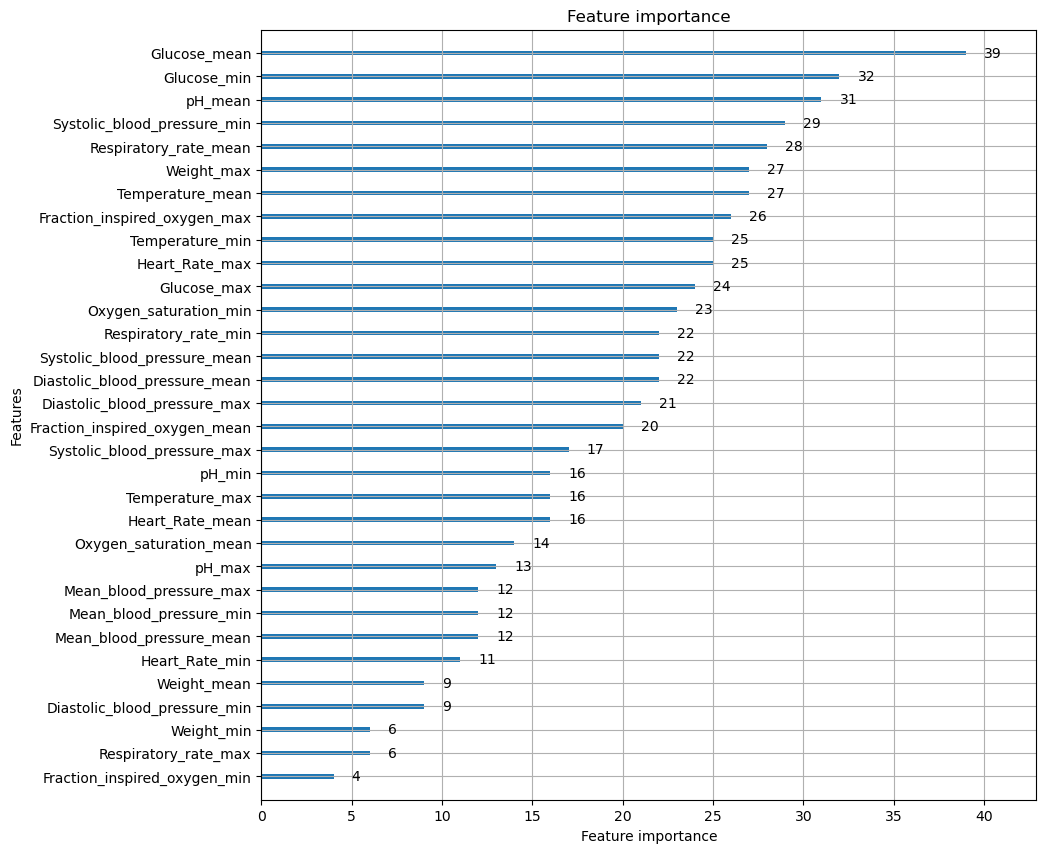

In [42]:
model.feature_importance()

lgb.plot_importance(model,figsize=(10,10))

In [43]:
#model = lgb.Booster(model_file='lightgbm_model.txt')
model.save_model("lightgbm/lightgbm_model.txt")

              precision    recall  f1-score   support

         0.0       0.78      0.96      0.86      1255
         1.0       0.63      0.22      0.32       440

    accuracy                           0.76      1695
   macro avg       0.71      0.59      0.59      1695
weighted avg       0.74      0.76      0.72      1695



<Axes: >

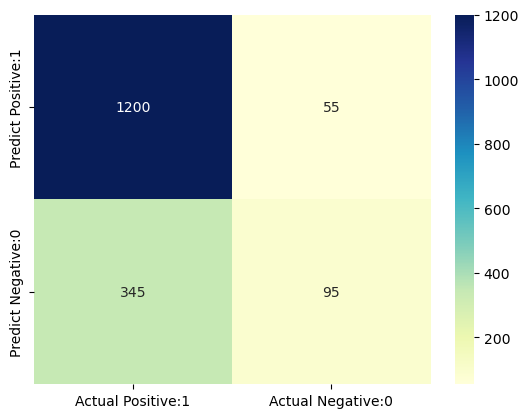

In [44]:

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

cm = confusion_matrix(y_test, y_val)
"""
print('Confusion matrix\n\n', cm)
print('\nTrue Positives(TP) = ', cm[0,0])
print('\nFalse Positives(FP) = ', cm[0,1])
print('\nFalse Negatives(FN) = ', cm[1,0])
print('\nTrue Negatives(TN) = ', cm[1,1])
"""

# visualize confusion matrix with seaborn heatmap

cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:1', 'Actual Negative:0'],
                                 index=['Predict Positive:1', 'Predict Negative:0'])

print(classification_report(y_test, y_val))

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')




AUC Score:  0.7452535313292284


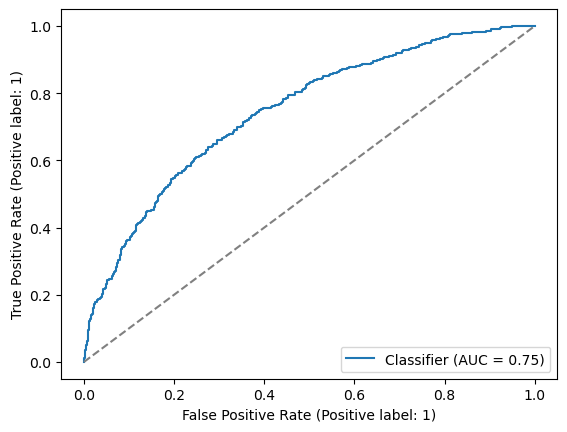

In [45]:
#https://towardsdatascience.com/understanding-the-roc-curve-in-three-visual-steps-795b1399481c
#https://scikit-learn.org/1.5/modules/generated/sklearn.metrics.RocCurveDisplay.html



import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay, roc_auc_score


print("AUC Score: ",roc_auc_score(y_test, y_val_prob))

roc_display = RocCurveDisplay.from_predictions(y_test, y_val_prob)

ax = roc_display.ax_

# Add the diagonal line x=y
ax.plot([0, 1], [0, 1], linestyle='--', color='gray')

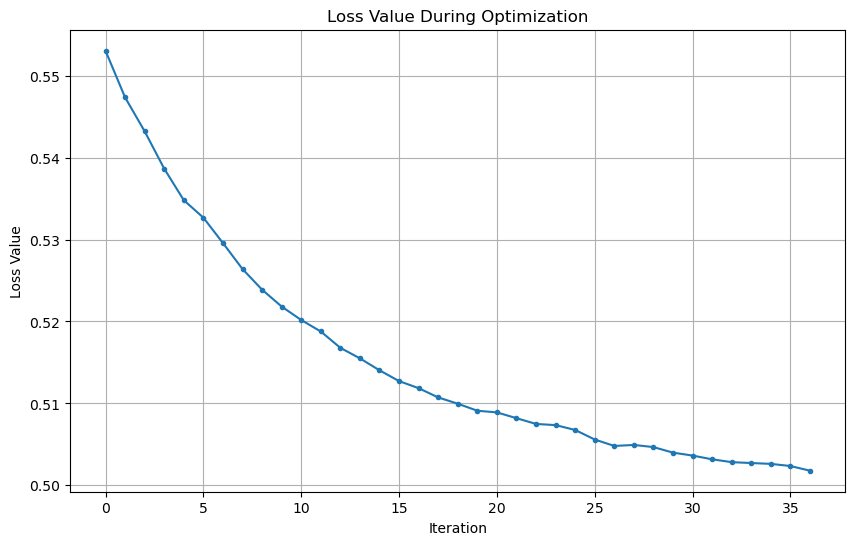

In [46]:
# Plot the loss values after optimization
plt.figure(figsize=(10, 6))
plt.plot(model_result['valid cross_entropy-mean'], marker='.', linestyle='-')
plt.title('Loss Value During Optimization')
plt.xlabel('Iteration')
plt.ylabel('Loss Value')
plt.grid()
plt.show()

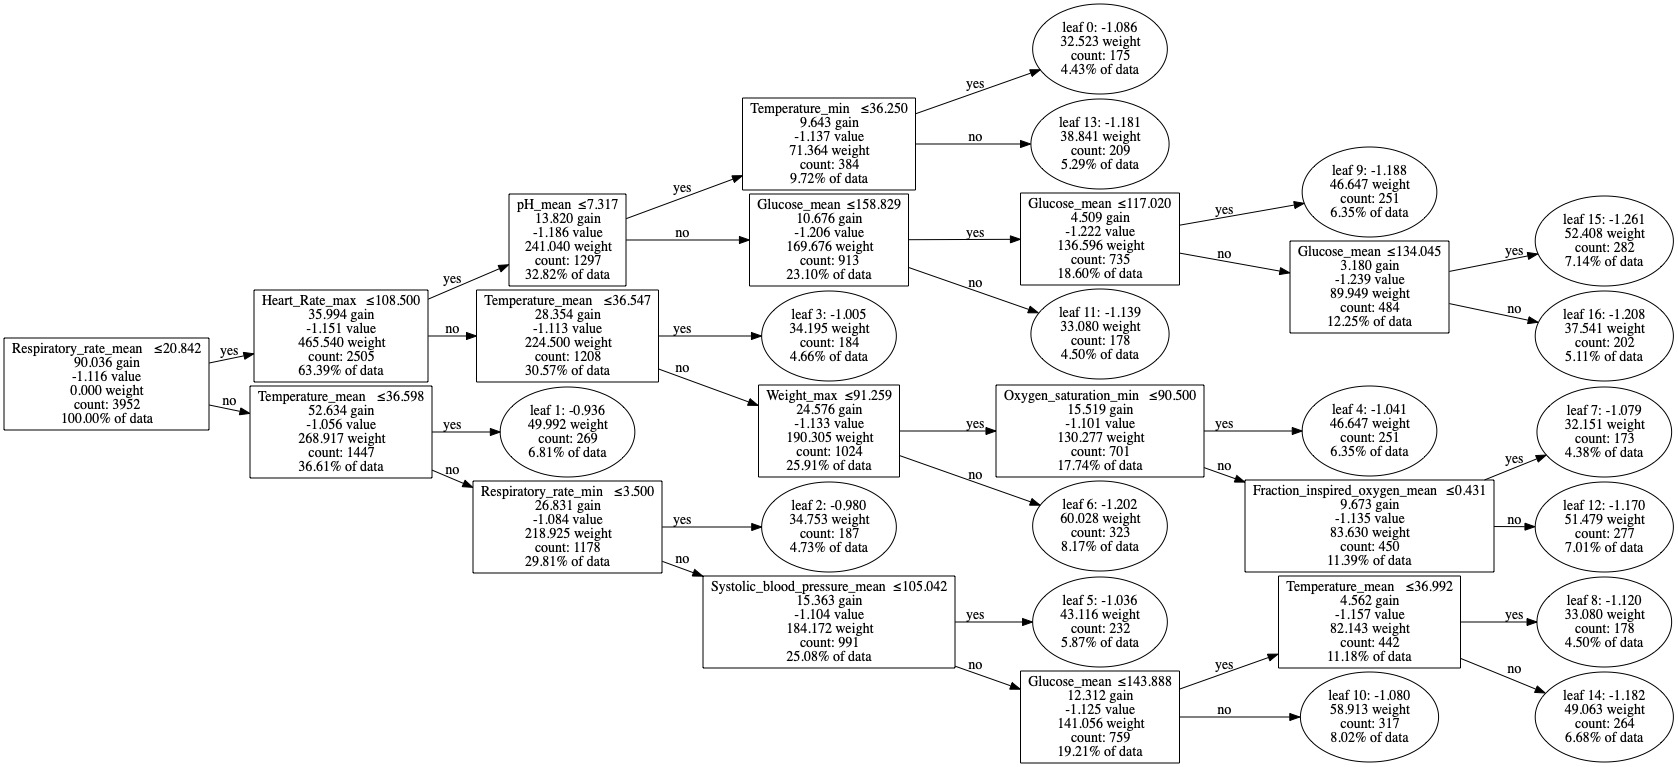

In [47]:
from PIL import Image

graph = lgb.create_tree_digraph(model, tree_index=0, show_info=['split_gain', 'internal_value', 'internal_count','internal_weight', 'leaf_count', 'leaf_weight', 'data_percentage'])

image=graph.render('lightgbm/lightgbm_plot_tree', format='jpg')

#image = Image.open("example.jpg")
#image.save("lightgbm_plot_tree.jpg")
#https://stackoverflow.com/questions/66475025/how-to-calculate-the-weight-and-value-in-lightgbm

image = Image.open("lightgbm/lightgbm_plot_tree.jpg")
image


In [48]:
from sklearn.metrics import f1_score, precision_score, recall_score

dec_pred=[i for i in np.arange(0.0,1.01,0.05)]

dec_f1_score=list()
this_precision=list()
this_recall=list()


for best_dec_pred in dec_pred:

      # https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMClassifier.html


      #print(f'\nLightGBM Model training accuracy, {f1_score(y_train, y_pred>best_dec_pred)}')


      y_val_t=y_val_prob>best_dec_pred

      this_f1_score=f1_score(y_test, y_val_t)
      this_precision.append(precision_score(y_test, y_val_t,average='macro',zero_division=0))
      this_recall.append(recall_score(y_test, y_val_t,average='macro',zero_division=0))

      dec_f1_score.append(this_f1_score)

      #print(f'\nLightGBM Model testing accuracy, {this_f1_score}')


F1 score reaches the top when threshold is  0.5224416517055656 at  0.25 .
Precision reaches the top when threshold is  0.8710821998817269 at  0.75 .
Recall reaches the top when threshold is  0.6780921767475552 at  0.25 .


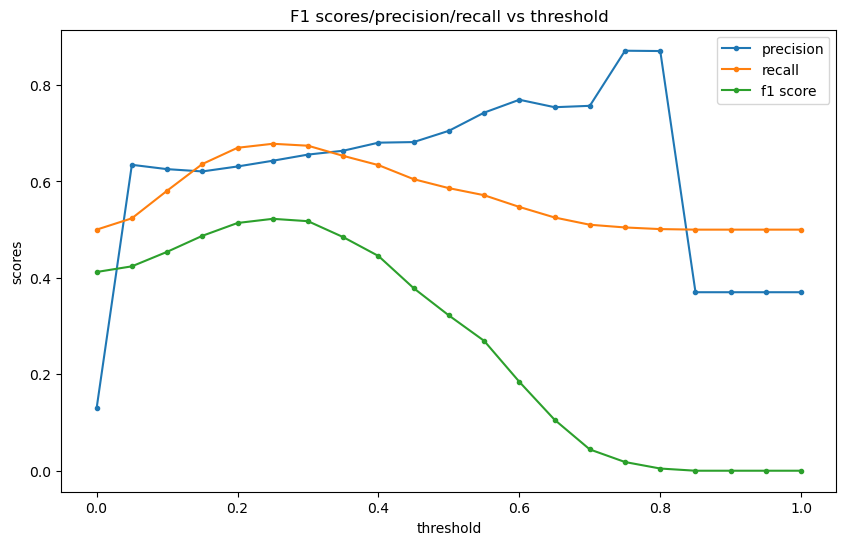

In [49]:
max_precision=max(this_precision)
max_precision_indx=round(dec_pred[this_precision.index(max_precision)],2)

max_f1_score=max(dec_f1_score)
max_f1_score_indx=round(dec_pred[dec_f1_score.index(max_f1_score)],2)

max_recall=max(this_recall)
max_recall_indx=round(dec_pred[this_recall.index(max_recall)],2)


print("F1 score reaches the top when threshold is ",max_f1_score,"at ",max_f1_score_indx,".")
print("Precision reaches the top when threshold is ",max_precision,"at ",max_precision_indx,".")
print("Recall reaches the top when threshold is ",max_recall,"at ",max_recall_indx,".")

# Plot the graph
plt.figure(figsize=(10, 6))

plt.plot(dec_pred,this_precision,marker='.', linestyle='-', label="precision")
plt.plot(dec_pred,this_recall,marker='.', linestyle='-', label="recall")
plt.plot(dec_pred,dec_f1_score,marker='.', linestyle='-', label="f1 score")

plt.title('F1 scores/precision/recall vs threshold')
plt.xlabel('threshold')
plt.ylabel('scores')
plt.legend()
plt.show()

In [50]:
#https://www.kaggle.com/code/adrianlievano/light-gbm-with-stratified-kfold

from sklearn.model_selection import  StratifiedKFold

cv_result=list()
f1_result=list()
acc_result=list()
cr_report=list()

skf = StratifiedKFold(n_splits = 10, shuffle=True, random_state=42)

skf.get_n_splits(X_train, y_train)

dec_threshold=0.5


for fold, (train_index, test_index) in enumerate(skf.split(X_train, y_train)):
    #print(train_index, test_index)
    #print(train_index.shape, test_index.shape)
    k_X_train, k_X_test = x.values[train_index], x.values[test_index]
    k_y_train, k_y_test = y.values[train_index], y.values[test_index]


    k_lgb_train = lgb.Dataset(k_X_train, k_y_train, params={'feature_pre_filter':False})
    k_lgb_test = lgb.Dataset(k_X_test, k_y_test, params={'feature_pre_filter':False})

    model_cv = lgb.train(
            params=lgbm_params,
            train_set=k_lgb_train,
            num_boost_round=100,
            feval=F1_metric,
            valid_sets=[k_lgb_train,k_lgb_test],
    )

    k_y_pred_prob=model_cv.predict(k_X_test)
    k_y_pred=k_y_pred_prob>dec_threshold

    cm_cv = confusion_matrix(k_y_test, k_y_pred)
    cv_result.append(cm_cv)
    f1_result.append(f1_score(k_y_test, k_y_pred))
    acc_result.append(accuracy_score(k_y_test, k_y_pred))
    cr_report.append(classification_report(k_y_test, k_y_pred))



#print(len(all_mse_val))


[LightGBM] [Info] [cross_entropy:Init]: (objective) labels passed interval [0, 1] check
[LightGBM] [Info] [cross_entropy:Init]: (metric) labels passed interval [0, 1] check
[LightGBM] [Info] [cross_entropy:Init]: sum-of-weights = 3556.000000
[LightGBM] [Info] Total Bins 5250
[LightGBM] [Info] Number of data points in the train set: 3556, number of used features: 33
[LightGBM] [Info] [cross_entropy:Init]: (metric) labels passed interval [0, 1] check
[LightGBM] [Info] [cross_entropy:Init]: sum-of-weights = 396.000000
[LightGBM] [Info] [cross_entropy:BoostFromScore]: pavg = 0.251969 -> initscore = -1.088141
[LightGBM] [Info] Start training from score -1.088141
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/gisellechan/anaconda3/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/gisellechan/anaconda3/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/gisellechan/anaconda3/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/gisellechan/anaconda3/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

/Users/gisellechan/anaconda3/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/gisellechan/anaconda3/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/gisellechan/anaconda3/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Did not meet early stopping. Best iteration is:
[37]	training's cross_entropy: 0.397519	training's F1: 0.508314	valid_1's cross_entropy: 0.501216	valid_1's F1: 0.388889
[LightGBM] [Info] [cross_entropy:Init]: (objective) labels passed interval [0, 1] check
[LightGBM] [Info] [cross_entropy:Init]: (metric) labels passed interval [0, 1] check
[LightGBM] [Info] [cross_entropy:Init]: sum-of-weights = 3

/Users/gisellechan/anaconda3/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/gisellechan/anaconda3/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/gisellechan/anaconda3/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Did not meet early stopping. Best iteration is:
[31]	training's cross_entropy: 0.414172	training's F1: 0.459438	valid_1's cross_entropy: 0.506749	valid_1's F1: 0.235294
[LightGBM] [Info] [cross_entropy:Init]: (objective) labels passed interval [0, 1] check
[LightGBM] [Info] [cross_entropy:Init]: (metric) labels passed interval [0, 1] check
[LightGBM] [Info] [cross_entropy:Init]: sum-of-weights = 3557.000000
[LightGBM] [Info] Total Bins 5241
[LightGBM] [Info] Number of data points in the train set: 3557, number of used features: 33
[LightGBM] [Info] [cross_entropy:Init]: (metric) labels passed interval [0, 1] check
[LightGBM] [Info] [cross_entropy:Init]: sum-of-weights = 395.000000
[LightGBM]

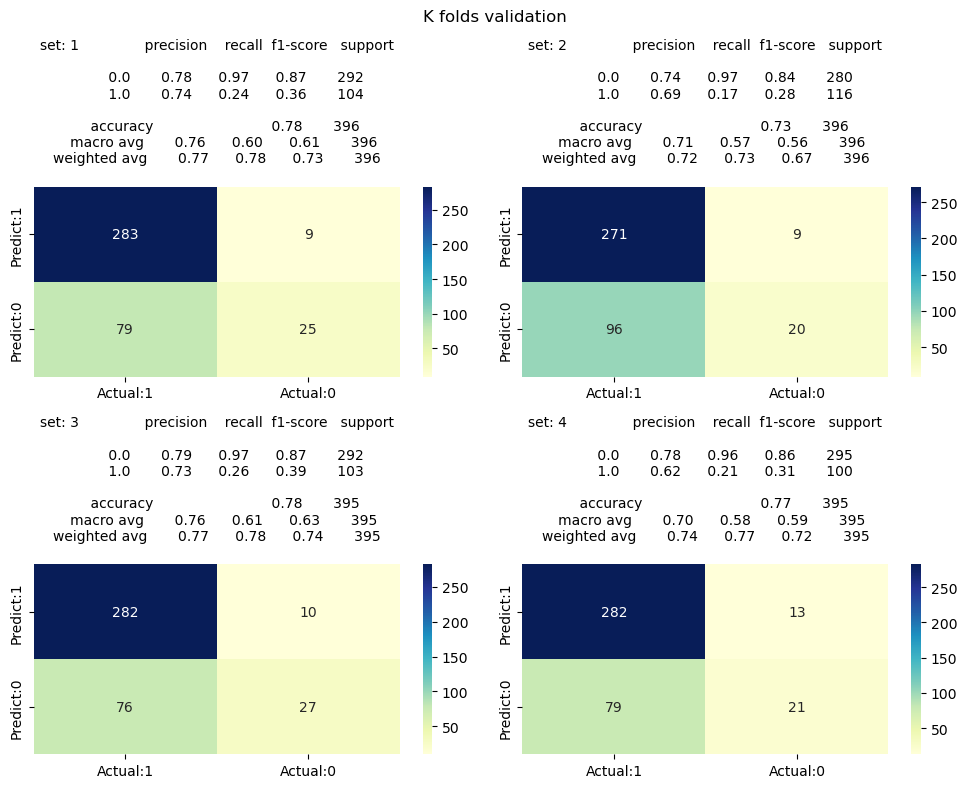

In [51]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

cm_matrix=list()
axes=np.empty((2, 2), dtype=object)



fig, axes = plt.subplots(ncols=2,nrows=2,figsize=(10, 8))
fig.suptitle("K folds validation")
fig.subplots_adjust(wspace=0.01)


# Plot each subplot
for k in range(4):
    row = k // 2
    col = k % 2
    #cm_matrix=cv_result[k]
    cm_matrix.append(pd.DataFrame(data=cv_result[k], columns=['Actual:1', 'Actual:0'],
                                 index=['Predict:1', 'Predict:0']))
    #axes[row][col].set_title(f'set: {k+1},\n accuracy:{round(acc_result[k],2)}, \nF1 score: {round(f1_result[k],2)}')
    axes[row][col].set_title(f'set: {k+1} {cr_report[k]}', fontsize=10)
    sns.heatmap(cm_matrix[k], annot=True, fmt='d',ax=axes[row][col], cmap='YlGnBu')


plt.tight_layout()